# Проект 10. Численные методы.

## Оценка стоимости автомобилей с пробегом

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.

Исходные данные - технические характеристики, комплектации и цены автомобилей. Задача - построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

<div class="alert alert-info"> <b>Комментарий студента:</b> Для начала импортируем все необходимые библиотеки, а также библиотеку для замера общего времени выполнения проекта. Примерное время расчета 6 минут, точная информация представлена в последней ячейке проекта </div>

In [1]:
import time
start = time.time()

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy import stats as st
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


from sklearn.metrics import  mean_squared_error



<div class="alert alert-info"> <b>Комментарий студента:</b> Проверим исходные данные и выполним небольшую предобработку </div>

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


<div class="alert alert-info"> <b>Комментарий студента:</b> Переведем столбцы в форматы даты </div>

In [5]:
df['date_crawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
df['date_created'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S')
df['last_seen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%d %H:%M:%S')
#df.info()

### Исследуем количественные признаки:

#### Для начала исследуем на аномалии:

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


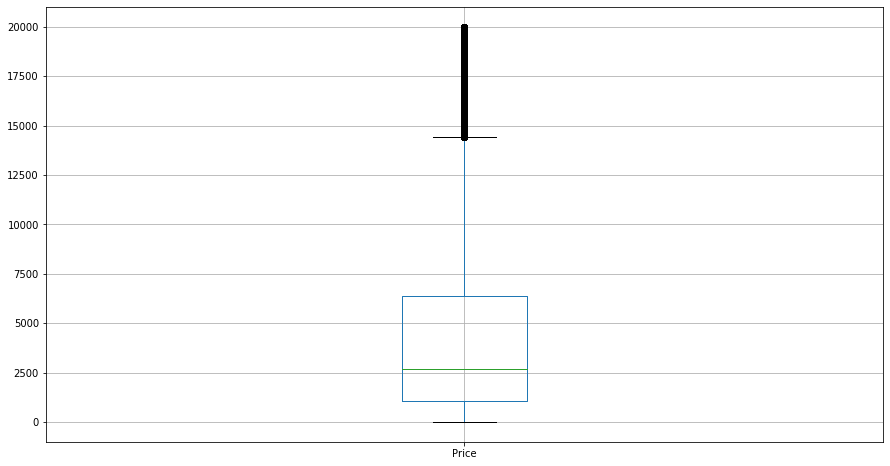

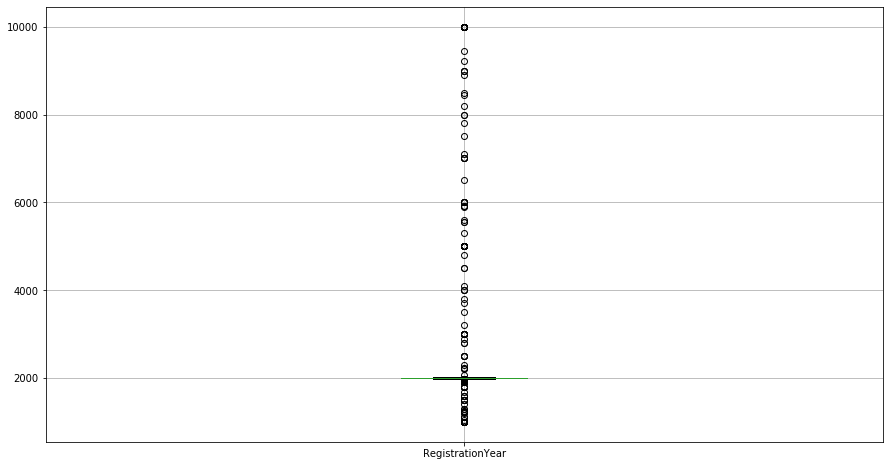

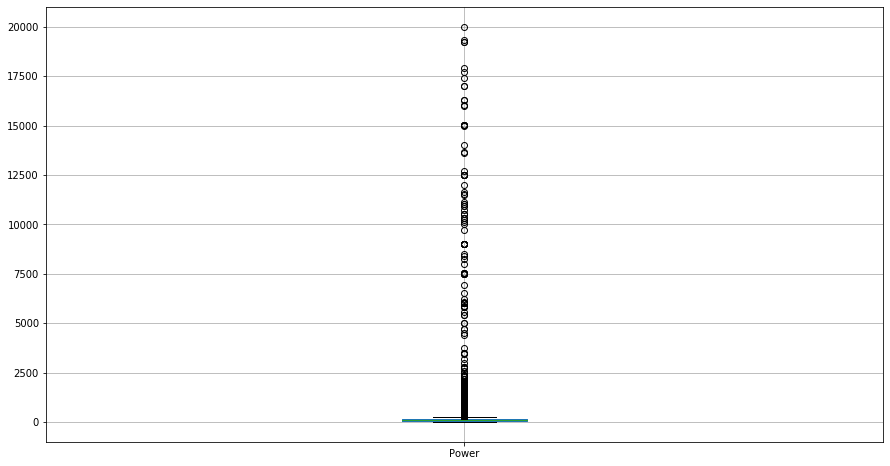

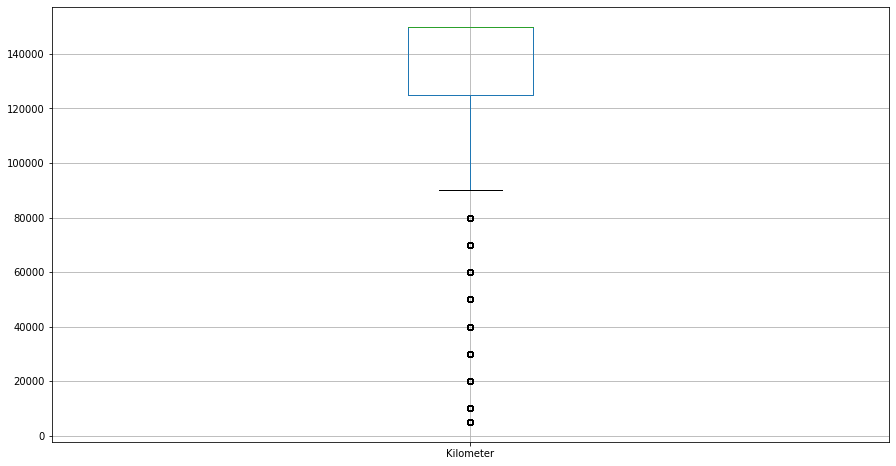

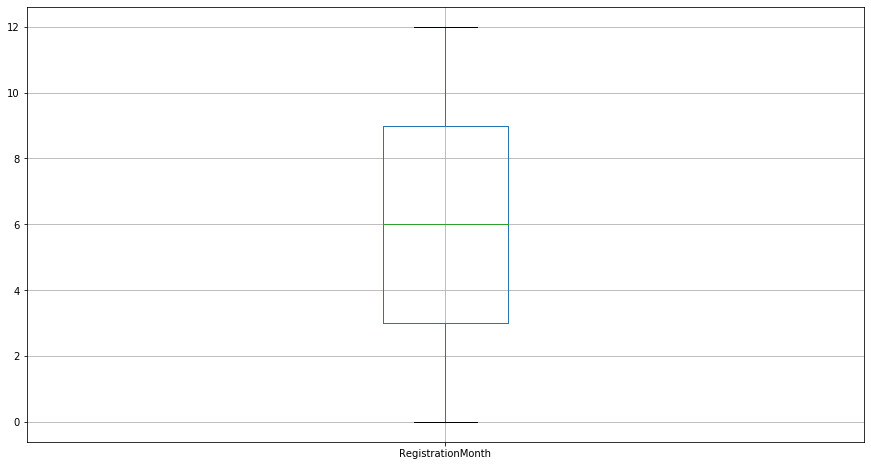

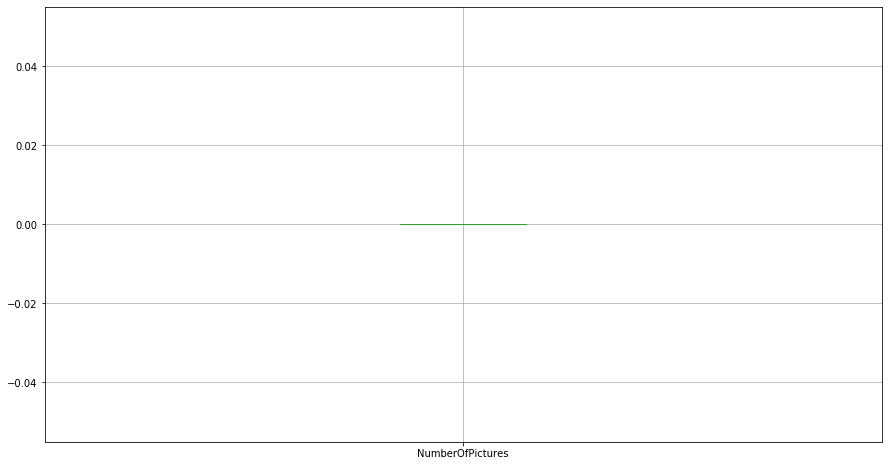

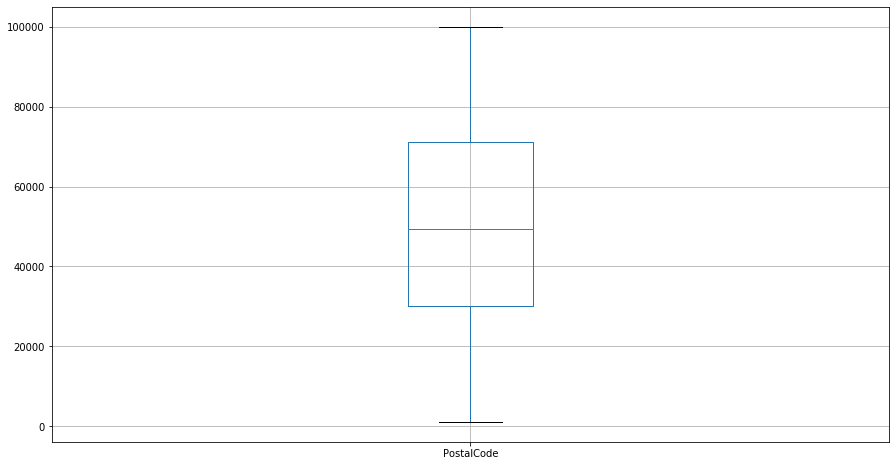

In [7]:
numerical = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode']
for column in numerical:
    plt.figure(figsize=(15, 8))
    df[[column]].boxplot()
    plt.show()

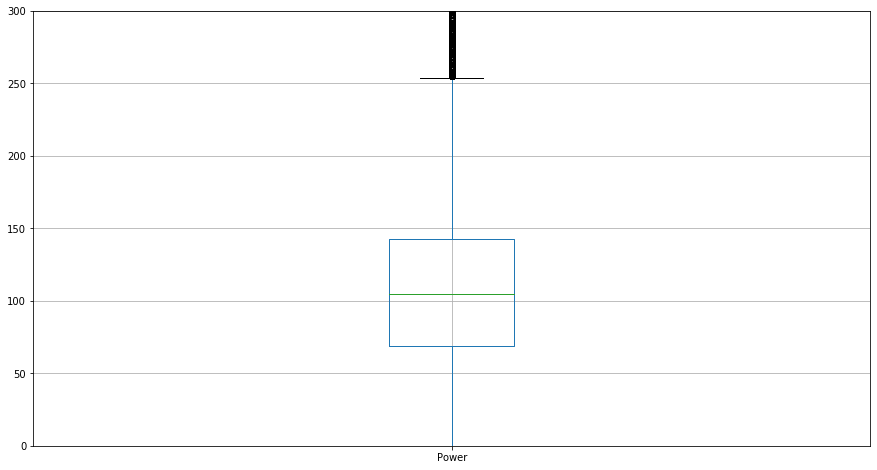

In [8]:
plt.figure(figsize=(15, 8))
df[['Power']].boxplot()
plt.ylim(0, 300)
plt.show()

In [9]:
df = df.query('RegistrationYear >= 1900 and RegistrationYear <= 2016 and Power <= 750')
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,339459.000000,339459.000000,339459.000000,339459.000000,339459.000000,339459.0,339459.000000
mean,4472.729620,2002.483740,107.607505,128089.283242,5.756480,0.0,50611.648016
std,4546.713111,7.088617,63.431248,37886.969628,3.708021,0.0,25806.663452
min,0.000000,1910.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1099.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30169.000000
50%,2799.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49497.000000
75%,6500.000000,2007.000000,143.000000,150000.000000,9.000000,0.0,71229.000000
max,20000.000000,2016.000000,750.000000,150000.000000,12.000000,0.0,99998.000000


In [10]:
df.drop(labels=['DateCrawled', 'DateCreated','LastSeen', 'NumberOfPictures', 'PostalCode'], axis=1, inplace=True)

#### Теперь заполним пропуски в количественных столбцах:

In [11]:
numerical = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
df[numerical].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339459 entries, 0 to 354368
Data columns (total 5 columns):
Price                339459 non-null int64
RegistrationYear     339459 non-null int64
Power                339459 non-null int64
Kilometer            339459 non-null int64
RegistrationMonth    339459 non-null int64
dtypes: int64(5)
memory usage: 15.5 MB


<div class="alert alert-warning"> <b>Комментарий студента:</b> А пропусков в количественных столбцах и нет, переходим к категориальным переменным </div>

### Рассмотрим категориальные переменные:

In [12]:
categorical = ['VehicleType','Gearbox', 'Model', 'FuelType', 'Brand',  'NotRepaired']
df[categorical].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339459 entries, 0 to 354368
Data columns (total 6 columns):
VehicleType    316570 non-null object
Gearbox        321566 non-null object
Model          321871 non-null object
FuelType       312265 non-null object
Brand          339459 non-null object
NotRepaired    274771 non-null object
dtypes: object(6)
memory usage: 18.1+ MB


In [13]:
for column in categorical:
    print(df[column].value_counts())
    print('-------------------------')

sedan          91368
small          79763
wagon          65097
bus            28744
convertible    20189
coupe          16147
suv            11987
other           3275
Name: VehicleType, dtype: int64
-------------------------
manual    257321
auto       64245
Name: Gearbox, dtype: int64
-------------------------
golf                  27599
other                 23854
3er                   19210
polo                  12441
corsa                 11927
                      ...  
kalina                    6
serie_3                   4
rangerover                3
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64
-------------------------
petrol      209825
gasoline     96236
lpg           5156
cng            540
hybrid         225
other          195
electric        88
Name: FuelType, dtype: int64
-------------------------
volkswagen        73124
opel              37952
bmw               35769
mercedes_benz     30977
audi              28456
ford 

In [14]:
print('Количество пропусков по категориям:\n', df[categorical].isna().sum()) #= df.fillna()
print('-------------')
print('Всего пропусков:', df[categorical].isna().sum().sum())
print('-------------')
print('Доля пропусков от всех строк:', np.round(df[categorical].isna().sum().sum() / df[categorical].shape[0], 2))

Количество пропусков по категориям:
 VehicleType    22889
Gearbox        17893
Model          17588
FuelType       27194
Brand              0
NotRepaired    64688
dtype: int64
-------------
Всего пропусков: 150252
-------------
Доля пропусков от всех строк: 0.44


In [15]:
df[categorical] = df[categorical].fillna('unknown')
#df.dropna(axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339459 entries, 0 to 354368
Data columns (total 14 columns):
Price                339459 non-null int64
VehicleType          339459 non-null object
RegistrationYear     339459 non-null int64
Gearbox              339459 non-null object
Power                339459 non-null int64
Model                339459 non-null object
Kilometer            339459 non-null int64
RegistrationMonth    339459 non-null int64
FuelType             339459 non-null object
Brand                339459 non-null object
NotRepaired          339459 non-null object
date_crawled         339459 non-null datetime64[ns]
date_created         339459 non-null datetime64[ns]
last_seen            339459 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(5), object(6)
memory usage: 38.8+ MB


In [16]:
for column in categorical:
    print(df[column].value_counts())
    print('-------------------------')

sedan          91368
small          79763
wagon          65097
bus            28744
unknown        22889
convertible    20189
coupe          16147
suv            11987
other           3275
Name: VehicleType, dtype: int64
-------------------------
manual     257321
auto        64245
unknown     17893
Name: Gearbox, dtype: int64
-------------------------
golf                  27599
other                 23854
3er                   19210
unknown               17588
polo                  12441
                      ...  
kalina                    6
serie_3                   4
rangerover                3
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 251, dtype: int64
-------------------------
petrol      209825
gasoline     96236
unknown      27194
lpg           5156
cng            540
hybrid         225
other          195
electric        88
Name: FuelType, dtype: int64
-------------------------
volkswagen        73124
opel              37952
bmw              

In [17]:
print('Количество пропусков по категориям:\n', df[categorical].isna().sum()) #= df.fillna()
print('-------------')
print('Всего пропусков:', df[categorical].isna().sum().sum())
print('-------------')
print('Доля пропусков от всех строк:', np.round(df[categorical].isna().sum().sum() / df[categorical].shape[0], 2))

Количество пропусков по категориям:
 VehicleType    0
Gearbox        0
Model          0
FuelType       0
Brand          0
NotRepaired    0
dtype: int64
-------------
Всего пропусков: 0
-------------
Доля пропусков от всех строк: 0.0


<div class="alert alert-warning"> <b>Комментарий студента:</b> Т.к. пропусков очень много, я заменил на категорию Unknown </div>

<div class="alert alert-info"> <b>Комментарий студента:</b> пункт 2 и 3 я совместил, т.к. структурировал по видам моделей данные разделы </div>

# 2. Обучение моделей

# 3. Анализ моделей

<div class="alert alert-info"> <b>Комментарий студента:</b> обработаем категориальные признаки и разделим на обучающую и валидационную выборку </div>

In [18]:
%%time
categorical_ohe = ['Brand', 'Model', 'Gearbox', 'NotRepaired', 'VehicleType', 'FuelType']#]
df_ohe = pd.get_dummies(df, drop_first=True, columns=categorical_ohe)   

#encoder = OrdinalEncoder()

#df_ohe['Model_encoder'] = encoder.fit_transform(df_ohe[['Model']])

#df_ohe['Brand_encoder'] = encoder.fit_transform(df_ohe[['Brand']])
#df_ohe['FuelType_encoder'] = encoder.fit_transform(df_ohe[['FuelType']])
#df_ohe['VehicleType_encoder'] = encoder.fit_transform(df_ohe[['VehicleType']])

#df_ohe.drop(['Model'], axis=1, inplace=True) #, 'VehicleType', 'FuelType', 'Brand'

#-------------------------
target = df_ohe['Price']
features = df_ohe.drop(['Price', 'last_seen', 'date_created', 'date_crawled'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

print(features_train.shape)
print(target_train.shape)

print(features_valid.shape)
print(target_valid.shape)

(254594, 312)
(254594,)
(84865, 312)
(84865,)
CPU times: user 2.46 s, sys: 248 ms, total: 2.71 s
Wall time: 2.72 s


In [19]:
df_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,date_crawled,date_created,last_seen,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_1,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_unknown,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,Gearbox_manual,Gearbox_unknown,NotRepaired_unknown,NotRepaired_yes,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,FuelType_electric,FuelType_gasoline,FuelType_hybrid,

In [20]:
features_train.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_1,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_unknown,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,Gearbox_manual,Gearbox_unknown,NotRepaired_unknown,NotRepaired_yes,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petro

<div class="alert alert-warning"> <b>Комментарий студента:</b> Я поисследовал разные варианты по кодированию категориальных признаков. В общем, огромное количество столбцов как ни странно показало наименьшую ошибку РМСЕ, поэтому я ординал кодировку закомментировал, оставил кодировку ОНЕ. Сравнение РМСЕ текстом подписал под каждой моделью </div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Теперь обучим и проверим работу разных видов моделей машинного обучения, замеряя время выполнения задач </div>

## Linear

In [21]:
%%time
model_linear = LinearRegression()
model_linear.fit(features_train, target_train)

CPU times: user 25.4 s, sys: 9.7 s, total: 35.1 s
Wall time: 35.1 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
%%time
predicted_linear = model_linear.predict(features_valid)

mse_linear = mean_squared_error(target_valid, predicted_linear)

print("MSE =", mse_linear)
print("RMSE =", mse_linear ** 0.5)

MSE = 7815871.9390219115
RMSE = 2795.688097592775
CPU times: user 141 ms, sys: 189 ms, total: 329 ms
Wall time: 288 ms


2575 ord+OHE

2457 OHE

In [23]:
import seaborn as sns
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_valid.columns).sort_values(ascending=False).head(10)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

#chart_feature_imp(model_linear)

linear model не имеет важности признаков?

## Decision tree

In [24]:
%%time
model_tree = DecisionTreeRegressor()
model_tree.fit(features_train, target_train)

CPU times: user 13.8 s, sys: 61.7 ms, total: 13.9 s
Wall time: 13.9 s


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [25]:
predicted_tree = model_tree.predict(features_valid)

mse_tree = mean_squared_error(target_valid, predicted_tree)

print("MSE =", mse_tree)
print("RMSE =", mse_tree ** 0.5)

MSE = 4684516.409332762
RMSE = 2164.3743690343317


1914 ord+OHE

1855 OHE

In [26]:
%%time
best_model = None 
best_result = 10000
best_depth = 0
for depth in range(1, 10, 1):
    model_tree = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train) 
    predicted_tree = model_tree.predict(features_valid) 
    result_tree = mean_squared_error(target_valid, predicted_tree) ** 0.5 
    if result_tree < best_result:
        best_model = model_tree
        best_result = result_tree
        best_depth = depth
        mse_tree = mean_squared_error(target_valid, predicted_tree)

print('best model depth =', best_depth)
print("MSE =", mse_tree)
print("RMSE =", mse_tree ** 0.5)

best model depth = 9
MSE = 4603974.410293467
RMSE = 2145.6873980832966
CPU times: user 30.9 s, sys: 2.71 s, total: 33.6 s
Wall time: 33.9 s


1840 ord+OHE

1838 OHE

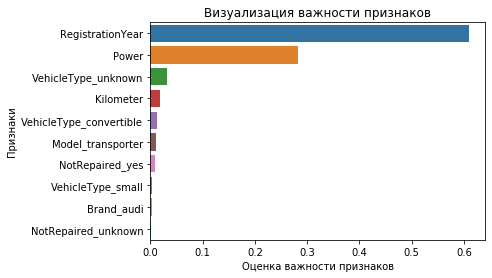

In [27]:
chart_feature_imp(model_tree)

<div class="alert alert-info"> <b>Комментарий студента:</b> лучшая модель с глубиной 9 имеет целевую метрику 1838 </div>

## Random Forest

In [28]:
%%time
model_forest = RandomForestRegressor()
model_forest.fit(features_train, target_train)

CPU times: user 1min 28s, sys: 300 ms, total: 1min 28s
Wall time: 1min 28s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [29]:
%%time
predicted_forest = model_forest.predict(features_valid)

mse_forest = mean_squared_error(target_valid, predicted_forest)

print("MSE =", mse_forest)
print("RMSE =", mse_forest ** 0.5)

MSE = 3136040.4202000457
RMSE = 1770.8869021481992
CPU times: user 731 ms, sys: 84.4 ms, total: 815 ms
Wall time: 828 ms


1535 ord+OHE

1527 OHE

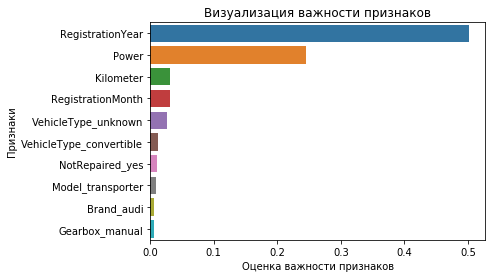

In [30]:
chart_feature_imp(model_forest)

%%time
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(10, 50, 10):
    for depth in range (1, 11):
        model_forest = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_train, target_train)
        predicted_forest = model_forest.predict(features_valid)
        result_forest = mean_squared_error(target_valid, predicted_forest) ** 0.5
        if result_forest < best_result:
            best_model = model_forest
            best_result = result_forest
            best_est = est
            best_depth = depth
            mse_forest = mean_squared_error(target_valid, predicted_forest)

            
print('Best forest depth =', best_depth)
print('Best number of estimators =', best_est)
print("MSE =", mse_forest)
print("RMSE =", mse_forest ** 0.5)

<div class="alert alert-info"> <b>Комментарий студента:</b> Расчет оказался слишком долгим! поэтому ячека закомментирована, результат забанен. 40 минут - непозволительно долго </div>

## CatBoost Regressor

In [31]:
%%time
model_cat = CatBoostRegressor(verbose=100)
model_cat.fit(features_train, target_train)

0:	learn: 4461.9858217	total: 179ms	remaining: 2m 58s
100:	learn: 2179.7333792	total: 19.6s	remaining: 2m 54s
200:	learn: 1996.4269014	total: 38.4s	remaining: 2m 32s
300:	learn: 1929.6055483	total: 57.1s	remaining: 2m 12s
400:	learn: 1887.2155813	total: 1m 15s	remaining: 1m 53s
500:	learn: 1856.3856592	total: 1m 34s	remaining: 1m 33s
600:	learn: 1832.1198854	total: 1m 53s	remaining: 1m 15s
700:	learn: 1813.5714768	total: 2m 12s	remaining: 56.4s
800:	learn: 1797.0416176	total: 2m 30s	remaining: 37.4s
900:	learn: 1783.2431882	total: 2m 49s	remaining: 18.6s
999:	learn: 1771.4828828	total: 3m 7s	remaining: 0us
CPU times: user 2min 45s, sys: 28.3 s, total: 3min 14s
Wall time: 3min 17s


In [32]:
%%time
predicted_cat = model_cat.predict(features_valid)

mse_cat = mean_squared_error(target_valid, predicted_cat)

print("MSE =", mse_cat)
print("RMSE =", mse_cat ** 0.5)

MSE = 3245516.1797587764
RMSE = 1801.5316205270383
CPU times: user 291 ms, sys: 58.5 ms, total: 349 ms
Wall time: 265 ms


1553 ord+OHE

1556 OHE

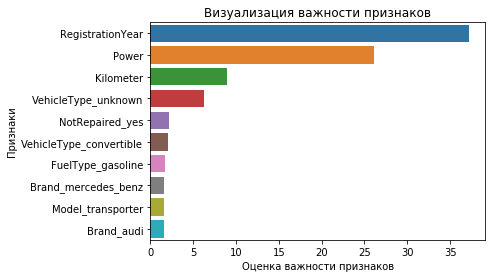

In [33]:
chart_feature_imp(model_cat)

## LGBM Regressor

In [34]:
%%time
model_lgb = LGBMRegressor()
model_lgb.fit(features_train, target_train)

CPU times: user 34.1 s, sys: 542 ms, total: 34.6 s
Wall time: 34.8 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [35]:
%%time
predicted_lgb = model_lgb.predict(features_valid)

mse_lgb = mean_squared_error(target_valid, predicted_lgb)

print("MSE =", mse_lgb)
print("RMSE =", mse_lgb ** 0.5)

MSE = 3264535.768348989
RMSE = 1806.8026368004307
CPU times: user 1.37 s, sys: 135 ms, total: 1.51 s
Wall time: 1.5 s


1561 ordinal+OHE

1553 c OHE

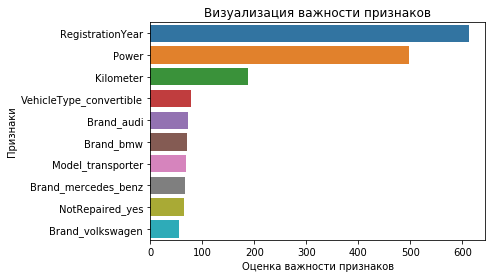

In [36]:
chart_feature_imp(model_lgb)

# Выводы

Выполнен и в последствии исправлен проект.

Что сделано:
- [x] Проведена предобработка данных, 
- [x] обучены разные модели машинного обучения
- [x] проведено сравнение значения целевой метрики и времени работы
- [x] выведена важность признаков для каждой модели

Интересный и совершенно логичный факт по поводу важности признаков: наиболее важный фактор это год выпуска автомобиля, мощность и пробег, поскольку это важные аспекты, относящиеся к технике и состоянию. А вот бренд, тип ТС, модель авто и другое это вкусовщина и является менее обязательным при оценке цены продажи автомобиля.

Я думаю, что наиболее подходящая модель для данной задачи - LGBM Regressor, так как имеет наименьшую ошибку, и имеет небольшое время работы - порядка 30 секунд.

Сравнение времени обучения, времени прогноза, ошибки РМСЕ представлено в таблице:

In [37]:
df_comparison = pd.DataFrame(
    np.array([['Linear', 33.3, 2457], ['Decision tree', 33.9, 1838], 
              ['Random forest', 87.8, 1527], ['CatBoost', 186.3, 1556], ['LGBM', 31.8, 1553]]), 
    columns=['model name', 'working time, sec', 'RMSE']
)

df_comparison.sort_values(by='RMSE', ascending=True)

,model name,"working time, sec",RMSE
2,Random forest,87.8,1527
4,LGBM,31.8,1553
3,CatBoost,186.3,1556
1,Decision tree,33.9,1838
0,Linear,33.3,2457


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей

In [38]:
end = time.time()
print(np.round((end - start)/60, 1), 'минут считается весь проект')

7.0 минут считается весь проект
